In [1]:
from cadcad.spaces import space
from cadcad.dynamics import block
from cadcad.spaces import Bit, Real, Integer, EmptySpace
from cadcad.points import Point
from cadcad.systems import Experiment
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(Bit)

Space Bit has dimensions {'bit': 'bool'}


In this notebook i will make a discrete time variant of a homocidal chaufeur

In [3]:

@space
class CartesianPlane:
    x:float
    y:float

CartesianPlaneDot = CartesianPlane.rename_dims({'x':'dx', 'y':'dy'})

@space
class Particle:
    pos:CartesianPlane
    vel:CartesianPlaneDot
    # used to encode a constraint
    #but this is exactly the kind of thing
    #i would like to push into the model params
    maxspeed : float

#this block serves as a kind of constraint checker for Particle
#i would like to be able to assign this block to the Space Particle
#as a builtin constraint
@block
def isValidParticle(domain:Point[Particle])-> Point[Bit]:
    input = domain
    dx= input['vel']['dx']
    dy= input['vel']['dy']

    vmax = input['maxspeed']

    output = {'bit':bool(dx**2+dy**2<=vmax**2)}

    return Point(Bit, output)

@block
def projectValidParticle(domain:Point[Particle])-> Point[Particle]:
    input = domain

    bit = isValidParticle(input)
    output = input
    if not(bit['bit']):
        dx= input['vel']['dx']
        dy= input['vel']['dy']
        magnitude = np.sqrt(dx**2+dy**2)
        output['vel']['dx'] = input['maxspeed']*dx/magnitude
        output['vel']['dy'] = input['maxspeed']*dy/magnitude
      
    return output


print(Particle)
Particle.unroll_schema()

Space Particle has dimensions {'pos': 'CartesianPlane', 'vel': 'CartesianPlane', 'maxspeed': 'float'}


{'pos': {'x': 'float', 'y': 'float'},
 'vel': {'dx': 'float', 'dy': 'float'},
 'maxspeed': 'float'}

In [4]:
Particle.dimensions()

{'pos': 'CartesianPlane', 'vel': 'CartesianPlane', 'maxspeed': 'float'}

In [5]:
CartesianPlaneDot.unroll_schema()

{'dx': 'float', 'dy': 'float'}

In [6]:
initAlice = Point(Particle, {'pos': {'x': 1.0, 'y': 1.0},
 'vel': {'dx': -.2, 'dy': .2}, 'maxspeed':.2})

In [7]:
print(initAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.2,
        "dy": 0.2
    },
    "maxspeed": 0.2
}



In [8]:
np.sqrt(.7071067811865475**2+.7071067811865475**2)


0.9999999999999999

In [9]:
print(isValidParticle(initAlice))

Point in space Bit has data
{
    "bit": false
}



In [10]:
print(projectValidParticle(initAlice))

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.1414213562373095,
        "dy": 0.1414213562373095
    },
    "maxspeed": 0.2
}



In [11]:

validInitAlice = deepcopy(projectValidParticle(initAlice))
#desirable UX
# validInitAlice = initAlice.apply(projectValidParticle)
print(validInitAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.1414213562373095,
        "dy": 0.1414213562373095
    },
    "maxspeed": 0.2
}



In [12]:
Acc = CartesianPlane.rename_dims({'x':'ddx', 'y':'ddy'})
Acc.unroll_schema()

{'ddx': 'float', 'ddy': 'float'}

In [13]:
AliceUpdateDomain = (Particle * Acc).rename_dims({'cartesianplane':"acc"})
AliceUpdateDomain.unroll_schema()

{'particle': {'pos': {'x': 'float', 'y': 'float'},
  'vel': {'dx': 'float', 'dy': 'float'},
  'maxspeed': 'float'},
 'acc': {'ddx': 'float', 'ddy': 'float'}}

In [14]:
@block
def particleSubspace(domain: Point[AliceUpdateDomain])-> Point[Particle]:
    input = domain
    return Point(Particle, input.data['particle'])

In [15]:

@block
def aliceUpdate(domain:Point[AliceUpdateDomain])-> Point[Particle]:
    input = domain
    output = particleSubspace(input)

    output['pos']['x']  += input['particle']['vel']['dx']
    output['pos']['y']  += input['particle']['vel']['dy']

    output['vel']['dx']  += input['acc']['ddx']
    output['vel']['dy']  += input['acc']['ddy']

    output = projectValidParticle(output)

    return output
    

In [16]:
import json
def printPretty(nestedDict,sort_keys=True, indent=4):
    print(json.dumps(nestedDict,sort_keys=sort_keys, indent=indent))

In [17]:
alice_acc_data = {'acc':{'ddx':-.5, 'ddy':-.1 }}
alice_acc_data['particle'] = deepcopy(validInitAlice.data)
printPretty(AliceUpdateDomain.unroll_schema())

{
    "acc": {
        "ddx": "float",
        "ddy": "float"
    },
    "particle": {
        "maxspeed": "float",
        "pos": {
            "x": "float",
            "y": "float"
        },
        "vel": {
            "dx": "float",
            "dy": "float"
        }
    }
}


In [18]:
printPretty(alice_acc_data)

{
    "acc": {
        "ddx": -0.5,
        "ddy": -0.1
    },
    "particle": {
        "maxspeed": 0.2,
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.1414213562373095,
            "dy": 0.1414213562373095
        }
    }
}


In [19]:
alice_update_input = Point(AliceUpdateDomain, alice_acc_data)

In [20]:
print(alice_update_input)

Point in space Particle*CartesianPlane has data
{
    "acc": {
        "ddx": -0.5,
        "ddy": -0.1
    },
    "particle": {
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.1414213562373095,
            "dy": 0.1414213562373095
        },
        "maxspeed": 0.2
    }
}



In [21]:
alice_new = deepcopy(aliceUpdate(alice_update_input))
print(initAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.1414213562373095,
        "dy": 0.1414213562373095
    },
    "maxspeed": 0.2
}



In [22]:
print(validInitAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.1414213562373095,
        "dy": 0.1414213562373095
    },
    "maxspeed": 0.2
}



In [23]:
print(alice_new)

Point in space Particle has data
{
    "pos": {
        "x": 0.8585786437626906,
        "y": 1.1414213562373094
    },
    "vel": {
        "dx": -0.1995842750873474,
        "dy": 0.012888643755571487
    },
    "maxspeed": 0.2
}



Currently it appears that we are updating the earlier point `initAlice` in the process of creating the new point `validInitAlice` and `alice_new` since they all have the same value.

## Bob Riding a Unicycle 

### Start by defining the polar plane as a space and the Unicycle as a space on the polar plane

In [24]:
@space
class PolarPlane:
    r:float
    theta:float

PolarPlaneDot = PolarPlane.rename_dims({'r':'dr', 'theta':'dtheta'})

@space
class Unicycle:
    pos: PolarPlane
    vel: PolarPlaneDot
    speed_max : float
    turn_max : float

print(Unicycle)
Unicycle.unroll_schema()

Space Unicycle has dimensions {'pos': 'PolarPlane', 'vel': 'PolarPlane', 'speed_max': 'float', 'turn_max': 'float'}


{'pos': {'r': 'float', 'theta': 'float'},
 'vel': {'dr': 'float', 'dtheta': 'float'},
 'speed_max': 'float',
 'turn_max': 'float'}

#### Create 2 constraints for motion of unicycle as a block for each, then create a block that gives the rules for handling both an input update and a constraint violation

In [25]:
@block
def isValidUnicycleSpeed(domain:Point[Unicycle])-> Point[Bit]:
    input = domain
    dr= input['vel']['dr']

    # speed_max would be in parameter space and should be independent from other agent's max speed
    vmax = input['speed_max']

    output = {'bit':bool(dr<=vmax)}

    return Point(Bit, output)

@block
def isValidUnicycleTurn(domain:Point[Unicycle])-> Point[Bit]:
    input = domain
    dtheta= input['vel']['dtheta']
    # turn_max would be in parameter space
    turn_max = input['turn_max']

    output = {'bit':bool(dtheta<=turn_max)}

    return Point(Bit, output)

@block
def projectValidUnicycle(domain:Point[Unicycle])-> Point[Unicycle]:
    input = domain

    speed_bit = isValidUnicycleSpeed(input)
    turn_bit = isValidUnicycleTurn(input)
    
    output = input
    if not(speed_bit['bit']) :
        output['vel']['dr'] = input['speed_max']

    if not(turn_bit['bit']):
        output['vel']['dtheta'] = input['turn_max']

    return output


print(Unicycle)
Unicycle.unroll_schema()

Space Unicycle has dimensions {'pos': 'PolarPlane', 'vel': 'PolarPlane', 'speed_max': 'float', 'turn_max': 'float'}


{'pos': {'r': 'float', 'theta': 'float'},
 'vel': {'dr': 'float', 'dtheta': 'float'},
 'speed_max': 'float',
 'turn_max': 'float'}

Initialize Bob on a Unicycle Point

In [26]:
initBob = Point(Unicycle, {'pos': {'r': 1.0, 'theta': np.pi/4},
    'vel': {'dr': 1.0, 'dtheta': np.pi/8},
    'speed_max': 2.0,
    'turn_max': np.pi/4})

Check Bob is valid against speed magnitude constraint

In [27]:
print(isValidUnicycleSpeed(initBob))

Point in space Bit has data
{
    "bit": true
}



Check Bob is valid against turning constraint

In [28]:
print(isValidUnicycleTurn(initBob))

Point in space Bit has data
{
    "bit": true
}



Check Bob's desired input values as projected output values

In [29]:
print(projectValidUnicycle(initBob))

Point in space Unicycle has data
{
    "pos": {
        "r": 1.0,
        "theta": 0.7853981633974483
    },
    "vel": {
        "dr": 1.0,
        "dtheta": 0.39269908169872414
    },
    "speed_max": 2.0,
    "turn_max": 0.7853981633974483
}



Create Bad Bob who knowingly exceeds the dr and dtheta constraints

In [30]:
initBadBob = Point(Unicycle, {'pos': {'r': 1.0, 'theta': np.pi/4},
    'vel': {'dr': 5.0, 'dtheta': np.pi/2},
    'speed_max': 2.0,
    'turn_max': np.pi/4})

Check Bad Bob against Constraints

In [31]:
print(isValidUnicycleSpeed(initBadBob))

Point in space Bit has data
{
    "bit": false
}



In [32]:
print(isValidUnicycleTurn(initBadBob))

Point in space Bit has data
{
    "bit": false
}



Check Bob's desired input values against projected output values with constraint application

In [33]:
print(projectValidUnicycle(initBadBob))

Point in space Unicycle has data
{
    "pos": {
        "r": 1.0,
        "theta": 0.7853981633974483
    },
    "vel": {
        "dr": 2.0,
        "dtheta": 0.7853981633974483
    },
    "speed_max": 2.0,
    "turn_max": 0.7853981633974483
}



### Create Unicycle Subspace for input of u

In [34]:
@block
def UnicycleSubspace(domain: Point[Unicycle])-> Point[Unicycle]:
    input = domain
    return Point(Unicycle, input.data)

### Create Block to update the Unicycle point with the input u

In [35]:
@block
def BobUpdate(domain:Point[Unicycle])-> Point[Unicycle]:
    input = domain
    output = UnicycleSubspace(input)
    output['pos']['r']  += input['vel']['dr']
    output['pos']['theta']  += input['vel']['dtheta']

    output['vel']['dr']  = input['vel']['dr']
    output['vel']['dtheta']  = input['vel']['dtheta']

    output = projectValidUnicycle(output)

    return output

### Input u

In [36]:
u_Bob = Point(Unicycle, {'pos': {'r': 1.0, 'theta': np.pi/4},
    'vel': {'dr': 5.0, 'dtheta': np.pi/10},
    'speed_max': 2.0,
    'turn_max': np.pi/4})

In [37]:
print(u_Bob)

Point in space Unicycle has data
{
    "pos": {
        "r": 1.0,
        "theta": 0.7853981633974483
    },
    "vel": {
        "dr": 5.0,
        "dtheta": 0.3141592653589793
    },
    "speed_max": 2.0,
    "turn_max": 0.7853981633974483
}



Use input u to update Bob

In [38]:
print(BobUpdate(u_Bob))

Point in space Unicycle has data
{
    "pos": {
        "r": 6.0,
        "theta": 1.0995574287564276
    },
    "vel": {
        "dr": 2.0,
        "dtheta": 0.3141592653589793
    },
    "speed_max": 2.0,
    "turn_max": 0.7853981633974483
}



### Create Dynamics

In [39]:
emptyPoint = Point(EmptySpace,{})
print(emptyPoint)

Point in space EmptySpace has data
{}



In [40]:
empty_Bob = Point(Unicycle, {'pos': {'r':0.0, 'theta': 0.0},
    'vel': {'dr': 0.0, 'dtheta': 0.0},
    'speed_max': np.infty,
    'turn_max': np.infty})

In [41]:
@block
def randomTurn(domain:Point[EmptySpace])-> Point[PolarPlaneDot]:
    input = deepcopy(domain)
    output = input
    # output = UnicycleSubspace(input)
    output = {}
    output['dr'] = 1.0
    output['dtheta'] = np.random.randn()/(2*np.pi)
    return Point(PolarPlaneDot, output)

In [42]:
@block
def randomPedal(domain:Point[EmptySpace])-> Point[PolarPlaneDot]:
    input = deepcopy(domain)
    output = input
    # output = UnicycleSubspace(input) #didn't work
    output = {}
    output['dr'] = np.random.randn()/(2)
    output['dtheta'] = 1.0
    return Point(PolarPlaneDot, output)

In [43]:
print(randomTurn(emptyPoint))

Point in space PolarPlane has data
{
    "dr": 1.0,
    "dtheta": 0.042208077949911514
}



In [44]:
print(randomPedal(emptyPoint))

Point in space PolarPlane has data
{
    "dr": -0.009664972739157077,
    "dtheta": 1.0
}



In [45]:
@block
def BobDynamics(domain:Point[Unicycle])->Point[Unicycle]:
    bob = deepcopy(domain)
    dtheta = randomTurn(emptyPoint)
    dr = randomPedal(emptyPoint)
    bob['vel']['dtheta'] = dtheta['dtheta']
    bob['vel']['dr'] = dr['dr']
    # print(bob)
    # args = Point(Unicycle, bob)

    output = BobUpdate(bob)

    return output

In [46]:
BobDynamics(initBob)

### Create Experiment

In [47]:
experiment_params = {"iteration_n": 5, "steps": 25}
my_experiment = Experiment(initBob, experiment_params, (BobDynamics,))

### Run Experiment

In [48]:
results = my_experiment.run()
results

### Observe Results

In [49]:
def flattenBob(results, exp_params):
    n = exp_params["iteration_n"]
    m = exp_params["steps"]
    dfs = []
    for j in range(n):
        d = results[j].data
        # print(d)
        r = np.zeros((m,4))
        for i in range(m):

            r[i,:]= [d[i]['pos']['r'], d[i]['pos']['theta'],d[i]['vel']['dr'], d[i]['vel']['dtheta']]
        df = pd.DataFrame(r, columns=['r','theta','dr','dtheta'])
        df["run"]  = j
        dfs.append(df)

    return pd.concat(dfs)

In [50]:
df = flattenBob(results,experiment_params)

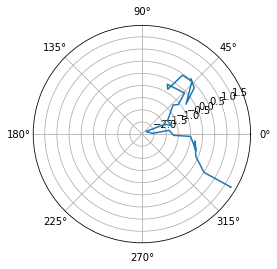

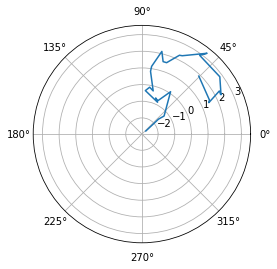

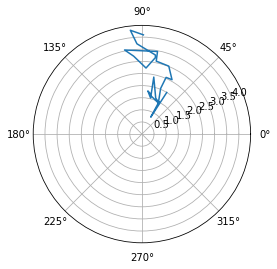

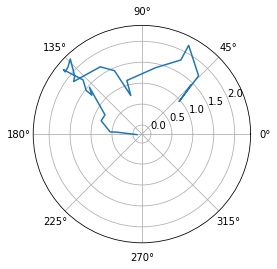

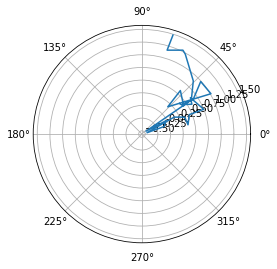

In [51]:
runs = df.run.unique()
for k in runs:
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(df[df.run==k].theta,df[df.run==k].r)
    r = df[df.run==k].values
    n = len(r)
    # for i in range(n):
    #     plt.arrow(*r[i,:4], width = 0.01, 
    #     length_includes_head=True)

In [68]:
@block
def polar2cartesian(domain: Point[PolarPlane]) -> Point[CartesianPlane]:
    
    r = domain["pos"]["r"]
    theta = domain["pos"]["theta"]

    x = r*np.cos(theta)
    y = r*np.sin(theta)

    # output = {"pos":{"x":x, "y":y} }
    output = {"x":x, "y":y}

    return Point(CartesianPlane, output)

In [93]:
def flattenBob2cart(results, exp_params):
    n = exp_params["iteration_n"]
    m = exp_params["steps"]
    dfs = []
    cart_df = []
    for j in range(n):
        d = results[j].data
        # print(d)
        r = np.zeros((m,2))
        for i in range(m):
            # print(d[i])
            cart_pts = polar2cartesian(d[i])
            # print(cart_pts.data)
            r[i,:]= [cart_pts['x'], cart_pts['y']]

        df = pd.DataFrame(r, columns=['x','y'])
        df["run"]  = j
        dfs.append(df)

    return pd.concat(dfs)

In [94]:
df = flattenBob2cart(results,experiment_params)

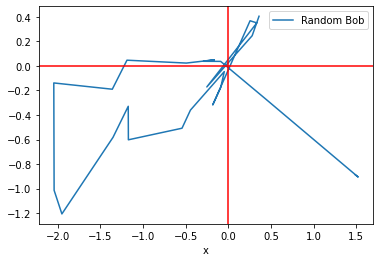

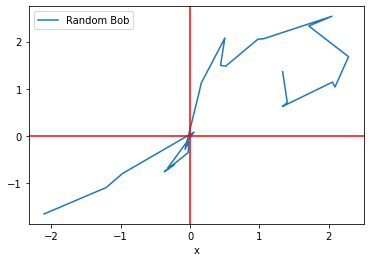

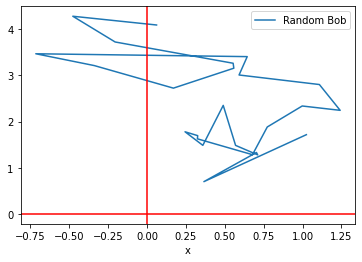

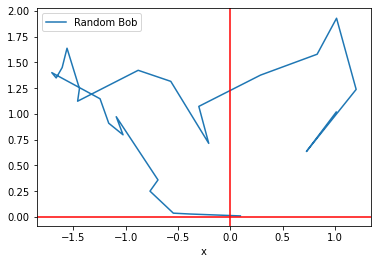

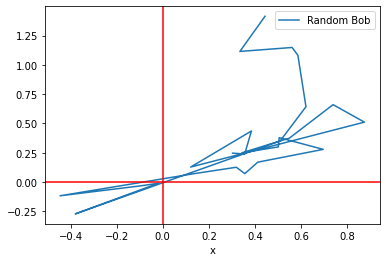

In [97]:
runs = df.run.unique()
for k in runs:
    df[df.run==k].plot(x="x", y='y',label = 'Random Bob',kind="line")
    plt.axvline(x=0, c="red", label="x=0")
    plt.axhline(y=0, c="red", label="y=0")
    r = df[df.run==k].values
    n = len(r)
    # for i in range(n):
    #     plt.arrow(*r[i,:2], width = 0.01, 
    #     length_includes_head=True)

In [52]:
PolarPlaneDot.unroll_schema()

{'dr': 'float', 'dtheta': 'float'}

In [53]:
@space
class GameState:
    alice: Particle
    bob: Unicycle

@space
class NormalizedGameState:
    alice: Particle
    bob: Particle

print(GameState)
GameState.unroll_schema()

Space GameState has dimensions {'alice': 'Particle', 'bob': 'Unicycle'}


{'alice': {'pos': {'x': 'float', 'y': 'float'},
  'vel': {'dx': 'float', 'dy': 'float'},
  'maxspeed': 'float'},
 'bob': {'pos': {'r': 'float', 'theta': 'float'},
  'vel': {'dr': 'float', 'dtheta': 'float'},
  'speed_max': 'float',
  'turn_max': 'float'}}

In [54]:
NormalizedGameState.unroll_schema()

{'alice': {'pos': {'x': 'float', 'y': 'float'},
  'vel': {'dx': 'float', 'dy': 'float'},
  'maxspeed': 'float'},
 'bob': {'pos': {'x': 'float', 'y': 'float'},
  'vel': {'dx': 'float', 'dy': 'float'},
  'maxspeed': 'float'}}

In [55]:


initBob = Point(Unicycle, {'pos': {'r': 1.0, 'theta': np.pi/4},
 'vel': {'dr': 1.0, 'dtheta': np.pi/8}})

init = Point(GameState, {'alice':initAlice.data, 'bob':initBob.data})

ValueError: zip() argument 2 is shorter than argument 1

In [ ]:
print(init)

Alice is a Particle Trying to Evade the Unicycle Bob so she will attempt to maximize her distance from Bob in the Next timesteo

In [ ]:
PolarPlaneDot.unroll_schema()

In [ ]:
PolarPlane.unroll_schema()

In [ ]:
@block
def awkwardConverter1(domain:Point[PolarPlaneDot])->Point[PolarPlane]:
    """"""
    input = domain
    output = {}
    output['r'] = input['dr']
    output['theta'] = input['dtheta']

    return Point(PolarPlane, output)
    
@block
def awkwardConverter2(domain:Point[CartesianPlane])->Point[CartesianPlaneDot]:
    """needs """
    input = domain
    output = {}
    output['dx'] = input['x']
    output['dy'] = input['y']

    return Point(CartesianPlaneDot, output)

In [ ]:
@block
def polar2cartesian(domain: Point[PolarPlane]) -> Point[CartesianPlane]:
    
    r = domain["r"]
    theta = domain["theta"]

    x = r*np.cos(theta)
    y = r*np.sin(theta)

    output = {"x":x, "y":y}

    return Point(CartesianPlane, output)

@block
def cartesian2polar(domain: Point[CartesianPlane]) -> Point[PolarPlane]:
    
    x = domain["x"]
    y = domain["y"]

    r = np.sqrt(x**2+y**2)
    if x==0:
        theta = np.sign(y)*np.pi/2
    else:
        theta = np.arctan(y/x)

    output = {"r":r, "theta":theta}

    return Point(PolarPlane, output)

@block
def normalize(domain:Point[GameState])->Point[NormalizedGameState]:
    #this is a piped block by hand
    #desired UX is to just write piping logic
    input=domain
    aliceData = input['alice']

    bobPosPolarPt = Point(PolarPlane, input['bob']['pos'])
    bobVelPolarDotPt = Point(PolarPlaneDot, input['bob']['vel'])
    print(bobVelPolarDotPt)
    bobVelPolarPt = awkwardConverter1(bobVelPolarDotPt)
    print(bobPosPolarPt)

    bobPosCartesian = polar2cartesian(bobPosPolarPt)

    bobVelCartesianTemp = polar2cartesian(bobVelPolarPt)
    print(bobVelCartesianTemp)

    bobVelCartesian=awkwardConverter2(bobVelCartesianTemp)
    print(bobVelCartesian)

    bobData = {'pos': bobPosCartesian.data, 'vel': bobVelCartesian.data}

    output = Point(NormalizedGameState, {'alice':aliceData, 'bob':bobData})

    return output



In [ ]:
normalizedInit = normalize(init)

In [ ]:
print(init)

In [ ]:
print(normalizedInit)

In [ ]:
bobpos = [normalizedInit["bob"]["pos"]["x"], normalizedInit["bob"]["pos"]["y"]]
bobvelarrow = [normalizedInit["bob"]["pos"]["x"], 
                normalizedInit["bob"]["pos"]["y"], 
                normalizedInit["bob"]["vel"]["dx"],
                normalizedInit["bob"]["vel"]["dy"]]

alicepos = [normalizedInit["alice"]["pos"]["x"], normalizedInit["alice"]["pos"]["y"]]
alicevelarrow = [normalizedInit["alice"]["pos"]["x"], 
                normalizedInit["alice"]["pos"]["y"], 
                normalizedInit["alice"]["vel"]["dx"],
                normalizedInit["alice"]["vel"]["dy"]]


In [ ]:
from curses import color_content
import matplotlib.pyplot as plt
import matplotlib.patches as patches

normalizedInit["bob"]["pos"]["x"]
 
# Adding an arrow to graph starting
# from the base (2, 4) and with the
# length of 2 units from both x and y
# And setting the width of arrow for
# better visualization

plt.arrow(*alicevelarrow, width = 0.05, color="pink")
plt.arrow(*bobvelarrow, width = 0.05, color="green")
a = plt.Circle(alicepos, radius=.02, color="red")
b = plt.Circle(bobpos, radius=.02, color="blue")
plt.gca().add_patch(a)
plt.gca().add_patch(b)



In [ ]:
bob_max_angle = np.pi/8
bob_max_speed = 1
alice_max_speed = np.sqrt(.2**2 + .2**2)

w = patches.Wedge(bobpos, bob_max_speed, (init["bob"]["vel"]["dtheta"]-bob_max_angle)*180/np.pi, (init["bob"]["vel"]["dtheta"]+bob_max_angle)*180/np.pi, alpha=.5)
plt.gca().add_patch(w)
c = plt.Circle(alicepos, radius=alice_max_speed, color="magenta", alpha=.5)
plt.gca().add_patch(c)
plt.arrow(*alicevelarrow, width = 0.05, color="pink", length_includes_head=True)
plt.arrow(*bobvelarrow, width = 0.05, color="green", length_includes_head=True)
a = plt.Circle(alicepos, radius=.02, color="red")
b = plt.Circle(bobpos, radius=.02, color="blue")
plt.gca().add_patch(a)
plt.gca().add_patch(b)


In [ ]:
bob_max_angle = np.pi/8
bob_max_speed = 1
alice_max_speed = np.sqrt(.2**2 + .2**2)

w = patches.Wedge(bobpos, bob_max_speed, (init["bob"]["vel"]["dtheta"]-bob_max_angle)*180/np.pi, (init["bob"]["vel"]["dtheta"]+bob_max_angle)*180/np.pi, alpha=.5)
plt.gca().add_patch(w)
c = plt.Circle(alicepos, radius=alice_max_speed, color="magenta", alpha=.5)
plt.gca().add_patch(c)
plt.arrow(*alicevelarrow, width = 0.05, color="pink", length_includes_head=True)
plt.arrow(*bobvelarrow, width = 0.05, color="green", length_includes_head=True)
a = plt.Circle(alicepos, radius=.02, color="red")
b = plt.Circle(bobpos, radius=.02, color="blue")
plt.gca().add_patch(a)
plt.gca().add_patch(b)